## A demo to plot time-series vertical profile (2D)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cmocean.cm as cm
from scipy.interpolate import interp1d

In [2]:
from lo_tools import Lfun
Ldir = Lfun.Lstart()

In [3]:
# Set global font sizes for all plots, now all subsequent plots will follow these settings
plt.rcParams.update({
    'axes.labelsize': 14,          # Labels font size
    'xtick.labelsize': 12,         # X-axis ticks font size
    'ytick.labelsize': 12,         # Y-axis ticks font size
    'axes.labelweight': 'bold',    # Bold axis labels
    'xtick.direction': 'in',       # X-axis tick direction
    'ytick.direction': 'in',       # Y-axis tick direction
    'font.size': 12,               # Default font size for other text
})

## Read Obs data (adjust to fit your own data)

In [4]:
# where the date from 
in_dir = Ldir['parent'] / 'LPM_output' / 'obsmod'
in_fn = in_dir / 'multi_bottle_nceiCoastal_LineP_1993_2021.p'

# read pickle data 
df0_dict = pickle.load(open(in_fn, 'rb'))  # use pd.read_csv if reading excel
# gtx = 'cas2k_v4_x2b' # name for the model run
# mod = df0_dict[gtx].copy()  # model

obs = df0_dict['obs'].copy()  # observations

# define where to save fig 
out_dir = Ldir['parent'] / 'LPM_output' / 'obsmod_plot'   # you can replace with '/a1/yifan/....'
Lfun.make_dir(out_dir)

In [5]:
# read obs data from LineP at P4 station
x = obs[(obs['source'] == 'LineP') & (obs['name'] == 'P4')]
# y = mod[(obs['source'] == 'LineP') & (obs['name'] == 'P4')]


In [6]:
label_dict = {
    'CT': '(a) CT',
    'SA': '(b) SA',
    'DO (uM)': '(c) DO $(\mu mol\ L^{-1})$',
    'NO3 (uM)': '(d) NO$_3\ (\mu mol\ L^{-1})$',
    'DIC (uM)': '(e) DIC $(\mu mol\ L^{-1})$',
    'TA (uM)':'(f) Alkalinity $(\mu mol\ L^{-1})$',
}

vn_list = label_dict.keys()

cm_list = {
    'CT': cm.thermal,
    'SA': cm.haline,
    'DO (uM)': cm.oxy,
    'NO3 (uM)': cm.speed.reversed(), # reverse the direction
    'DIC (uM)': cm.matter,
    'TA (uM)': cm.dense,
}

## try scatterplot first
* it doesn't manipulate the data but only color-mapped
* your data points might be too many to see the data gaps (in my case, data gaps are obvious)

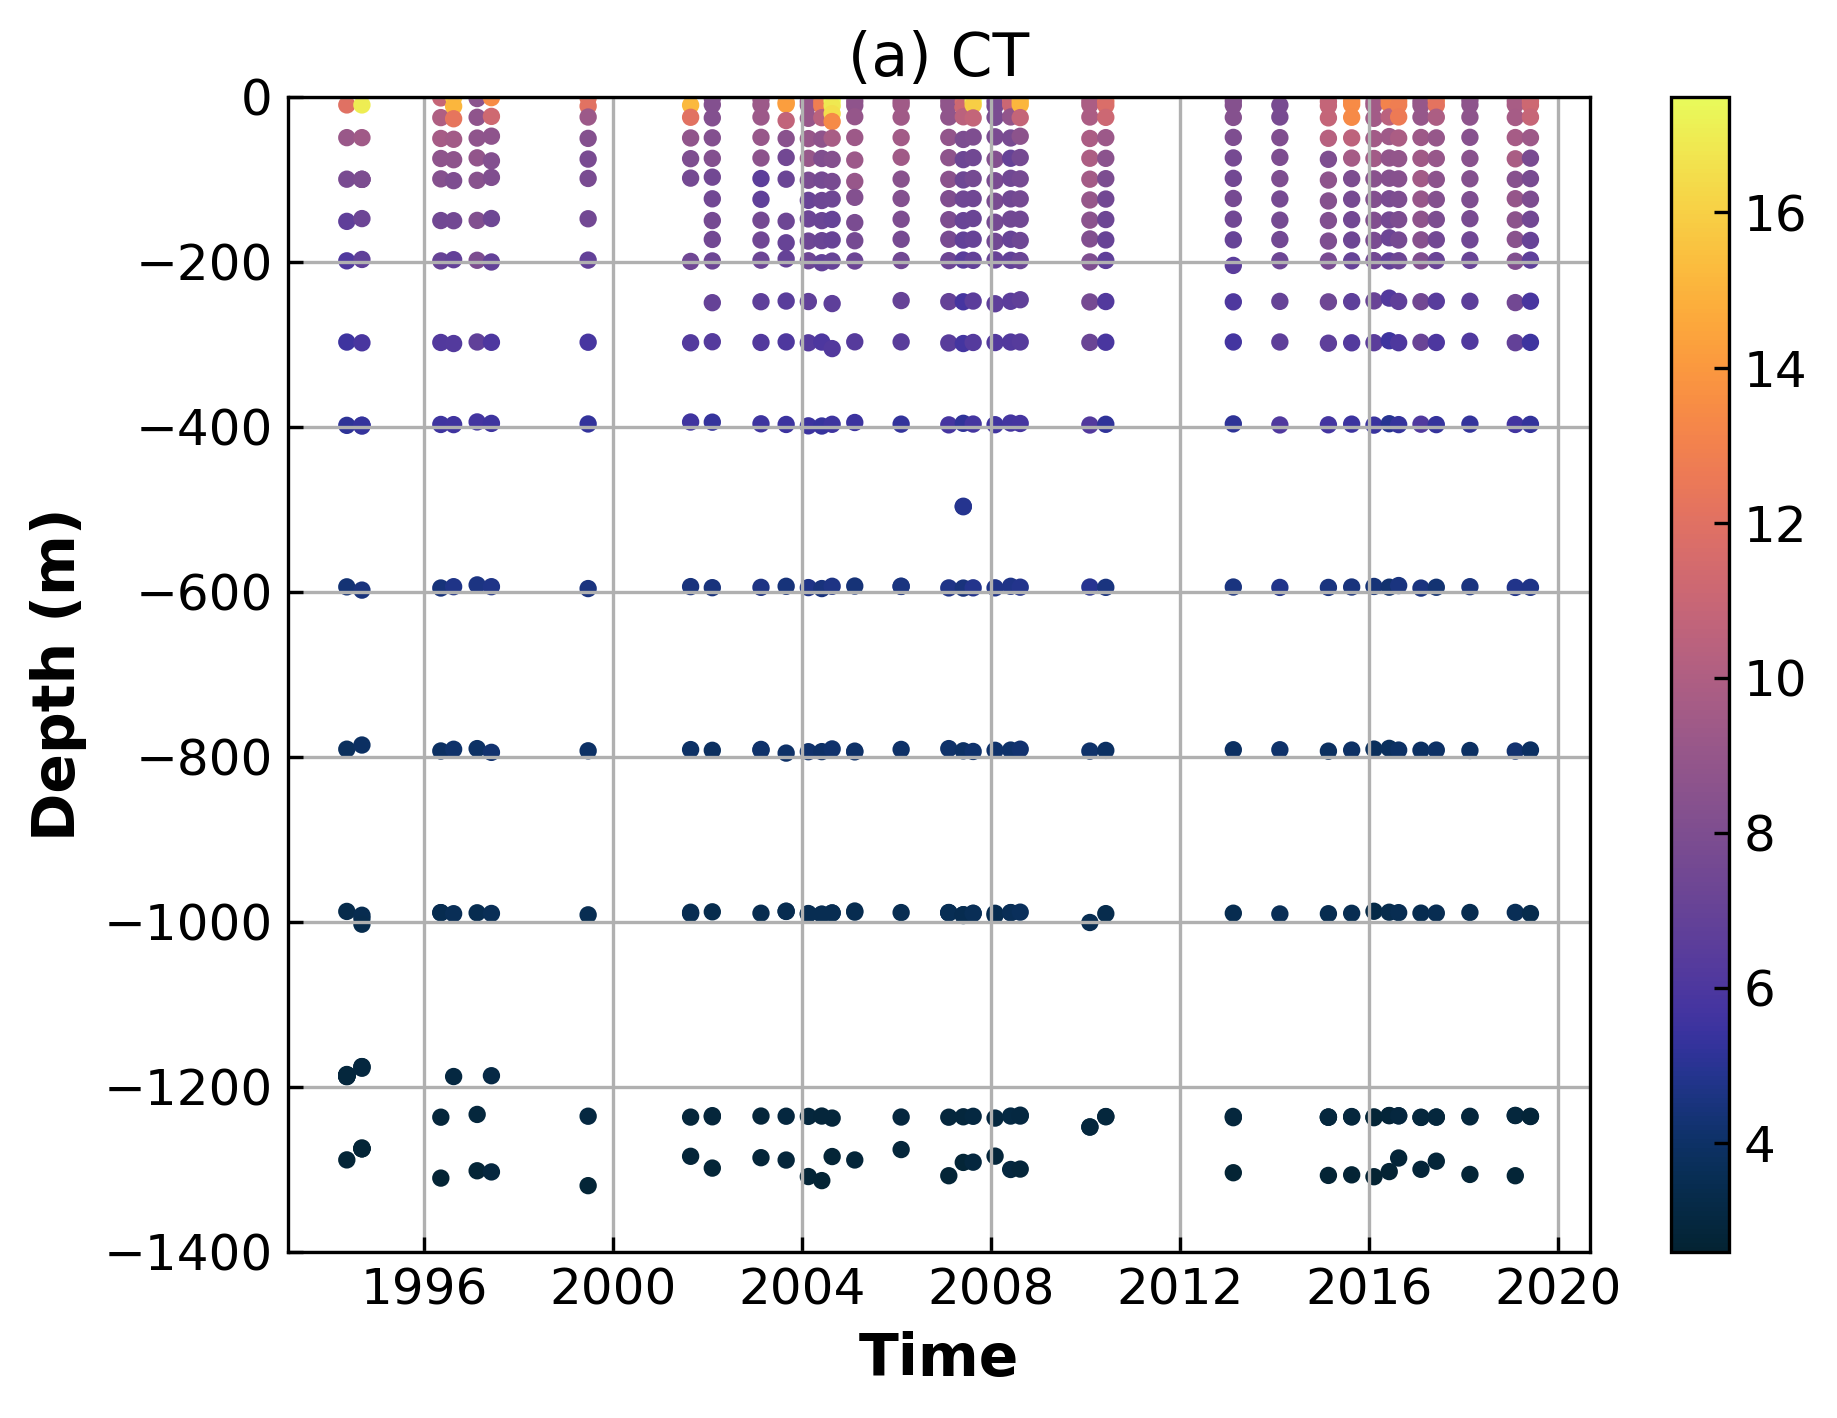

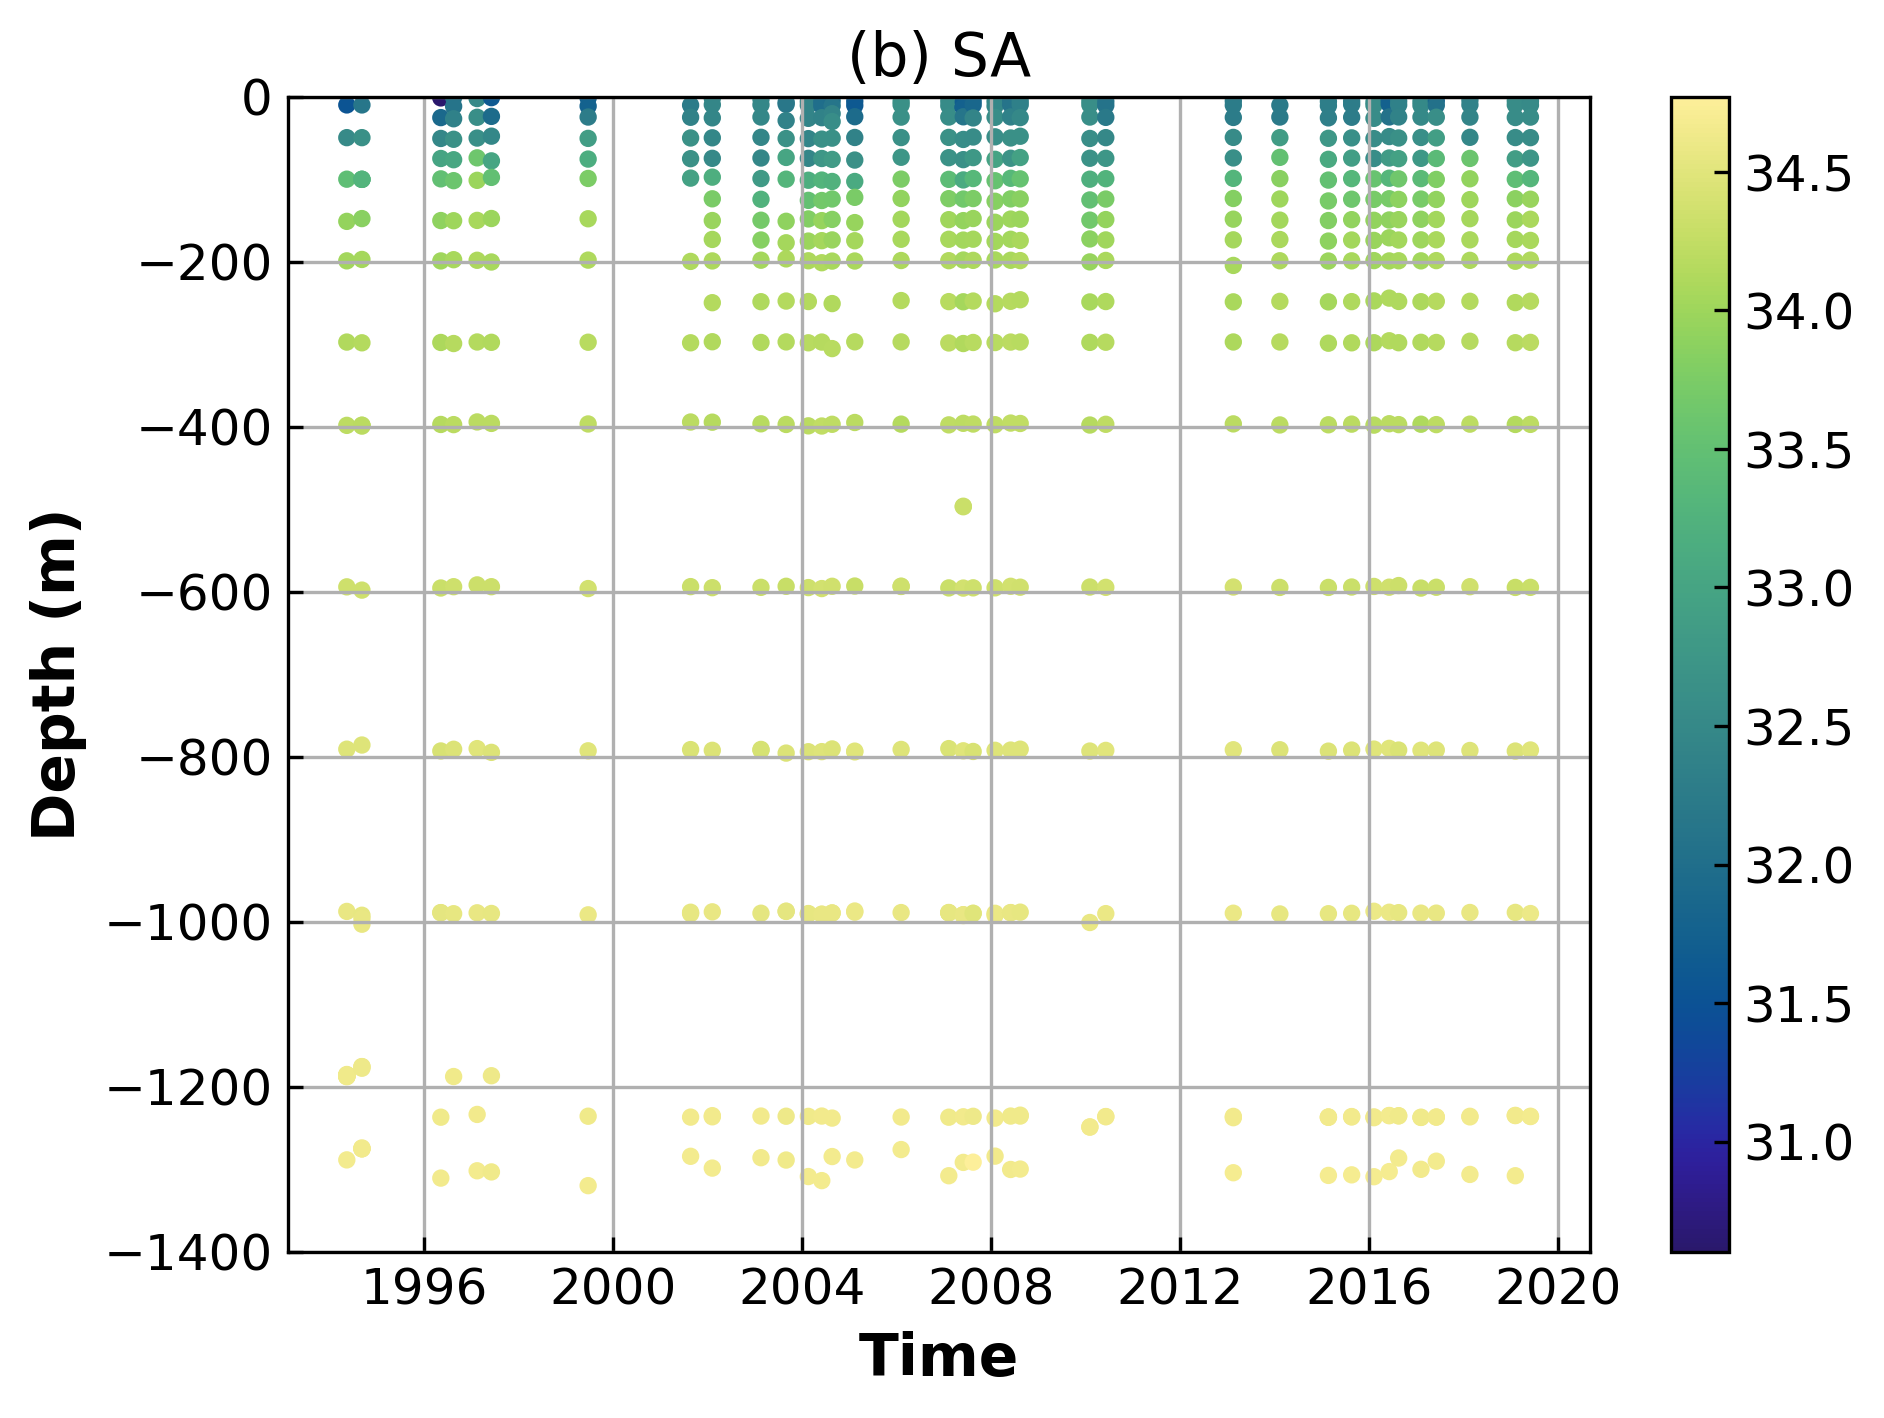

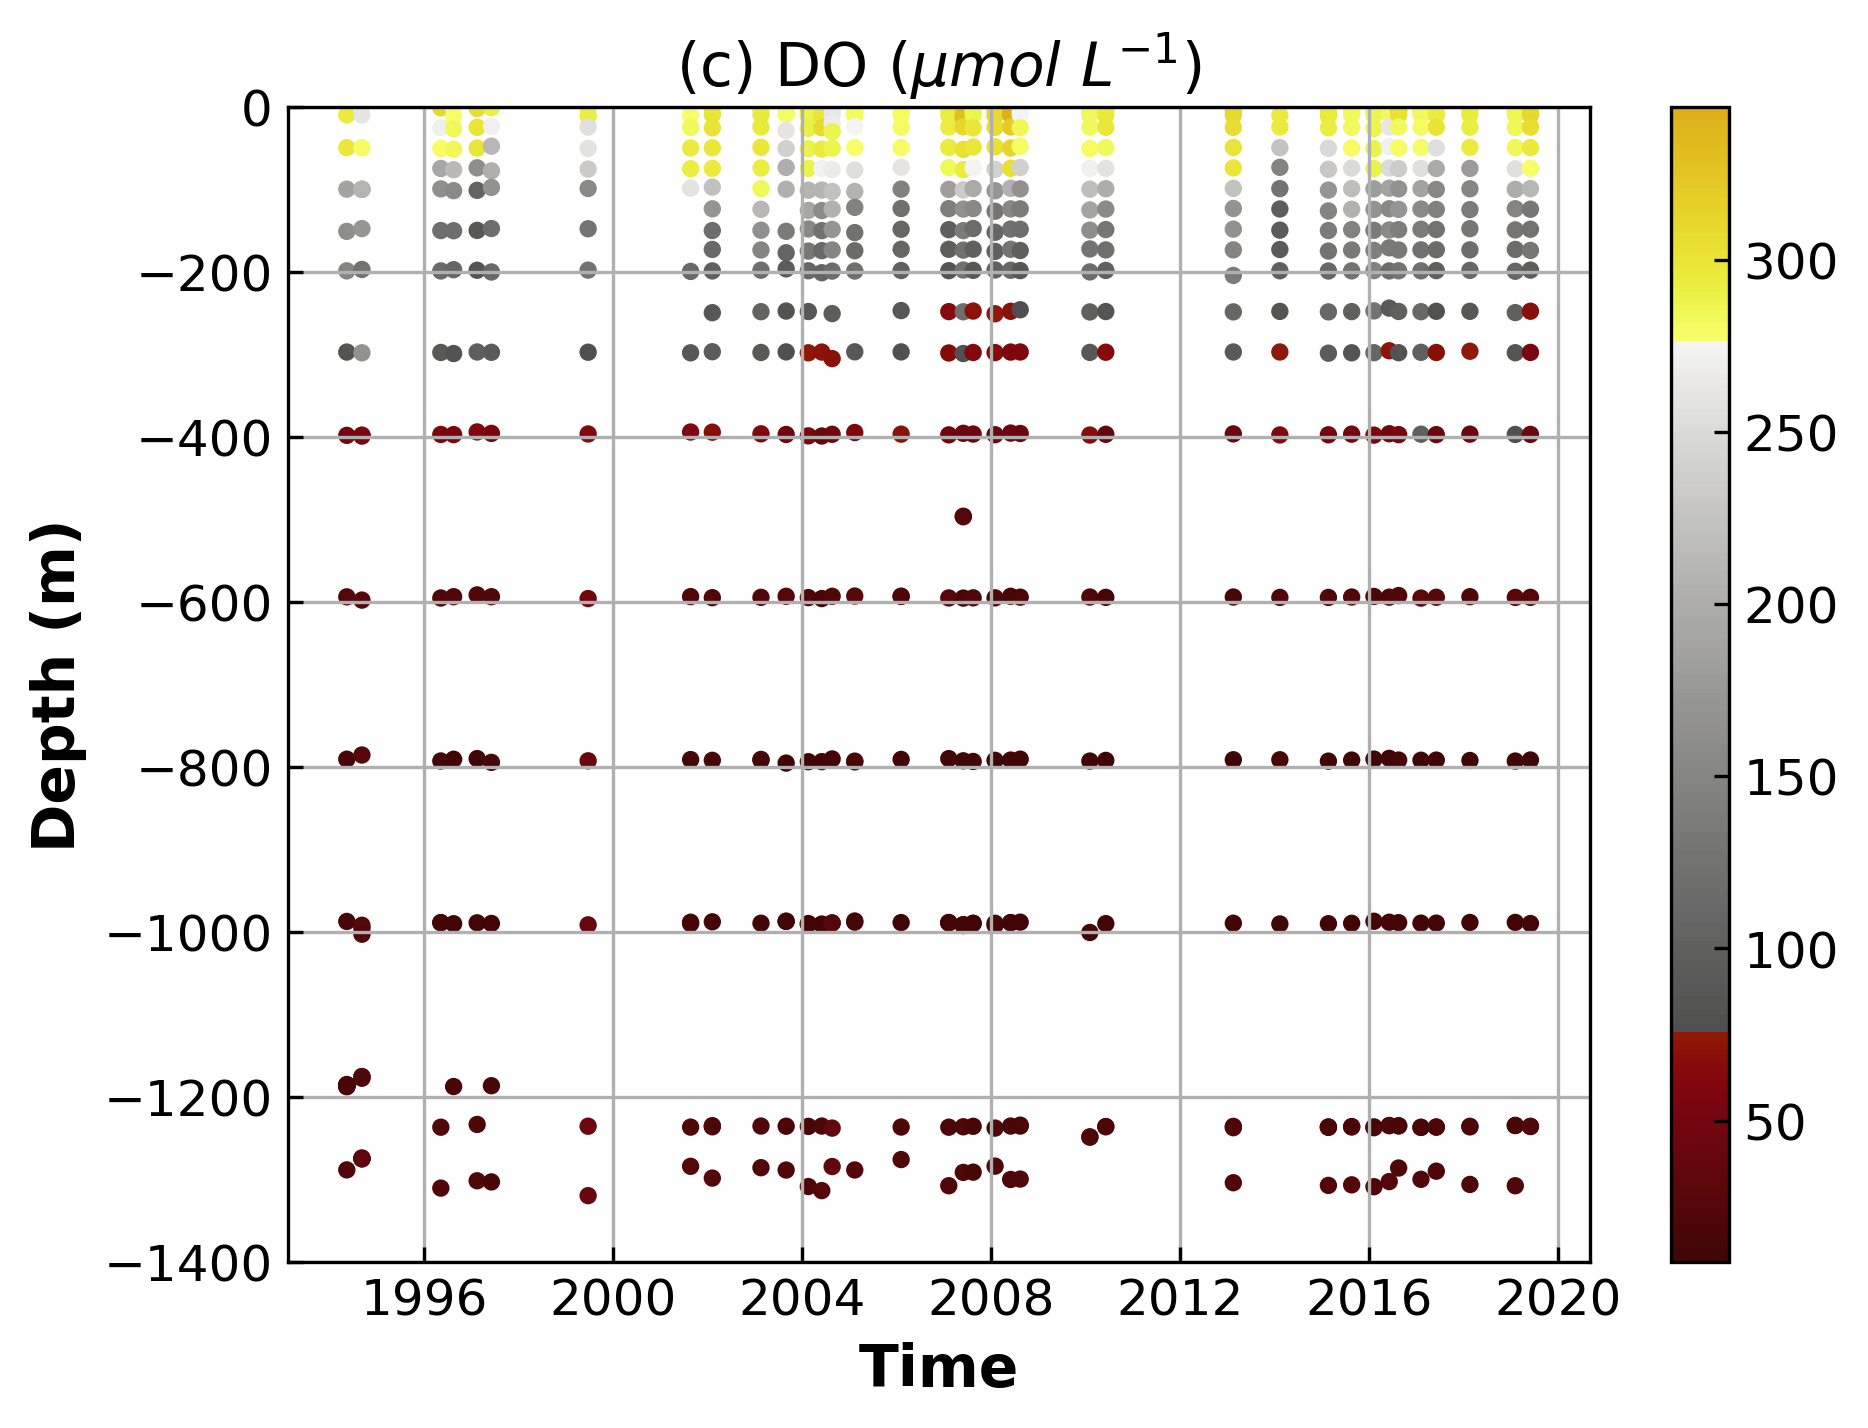

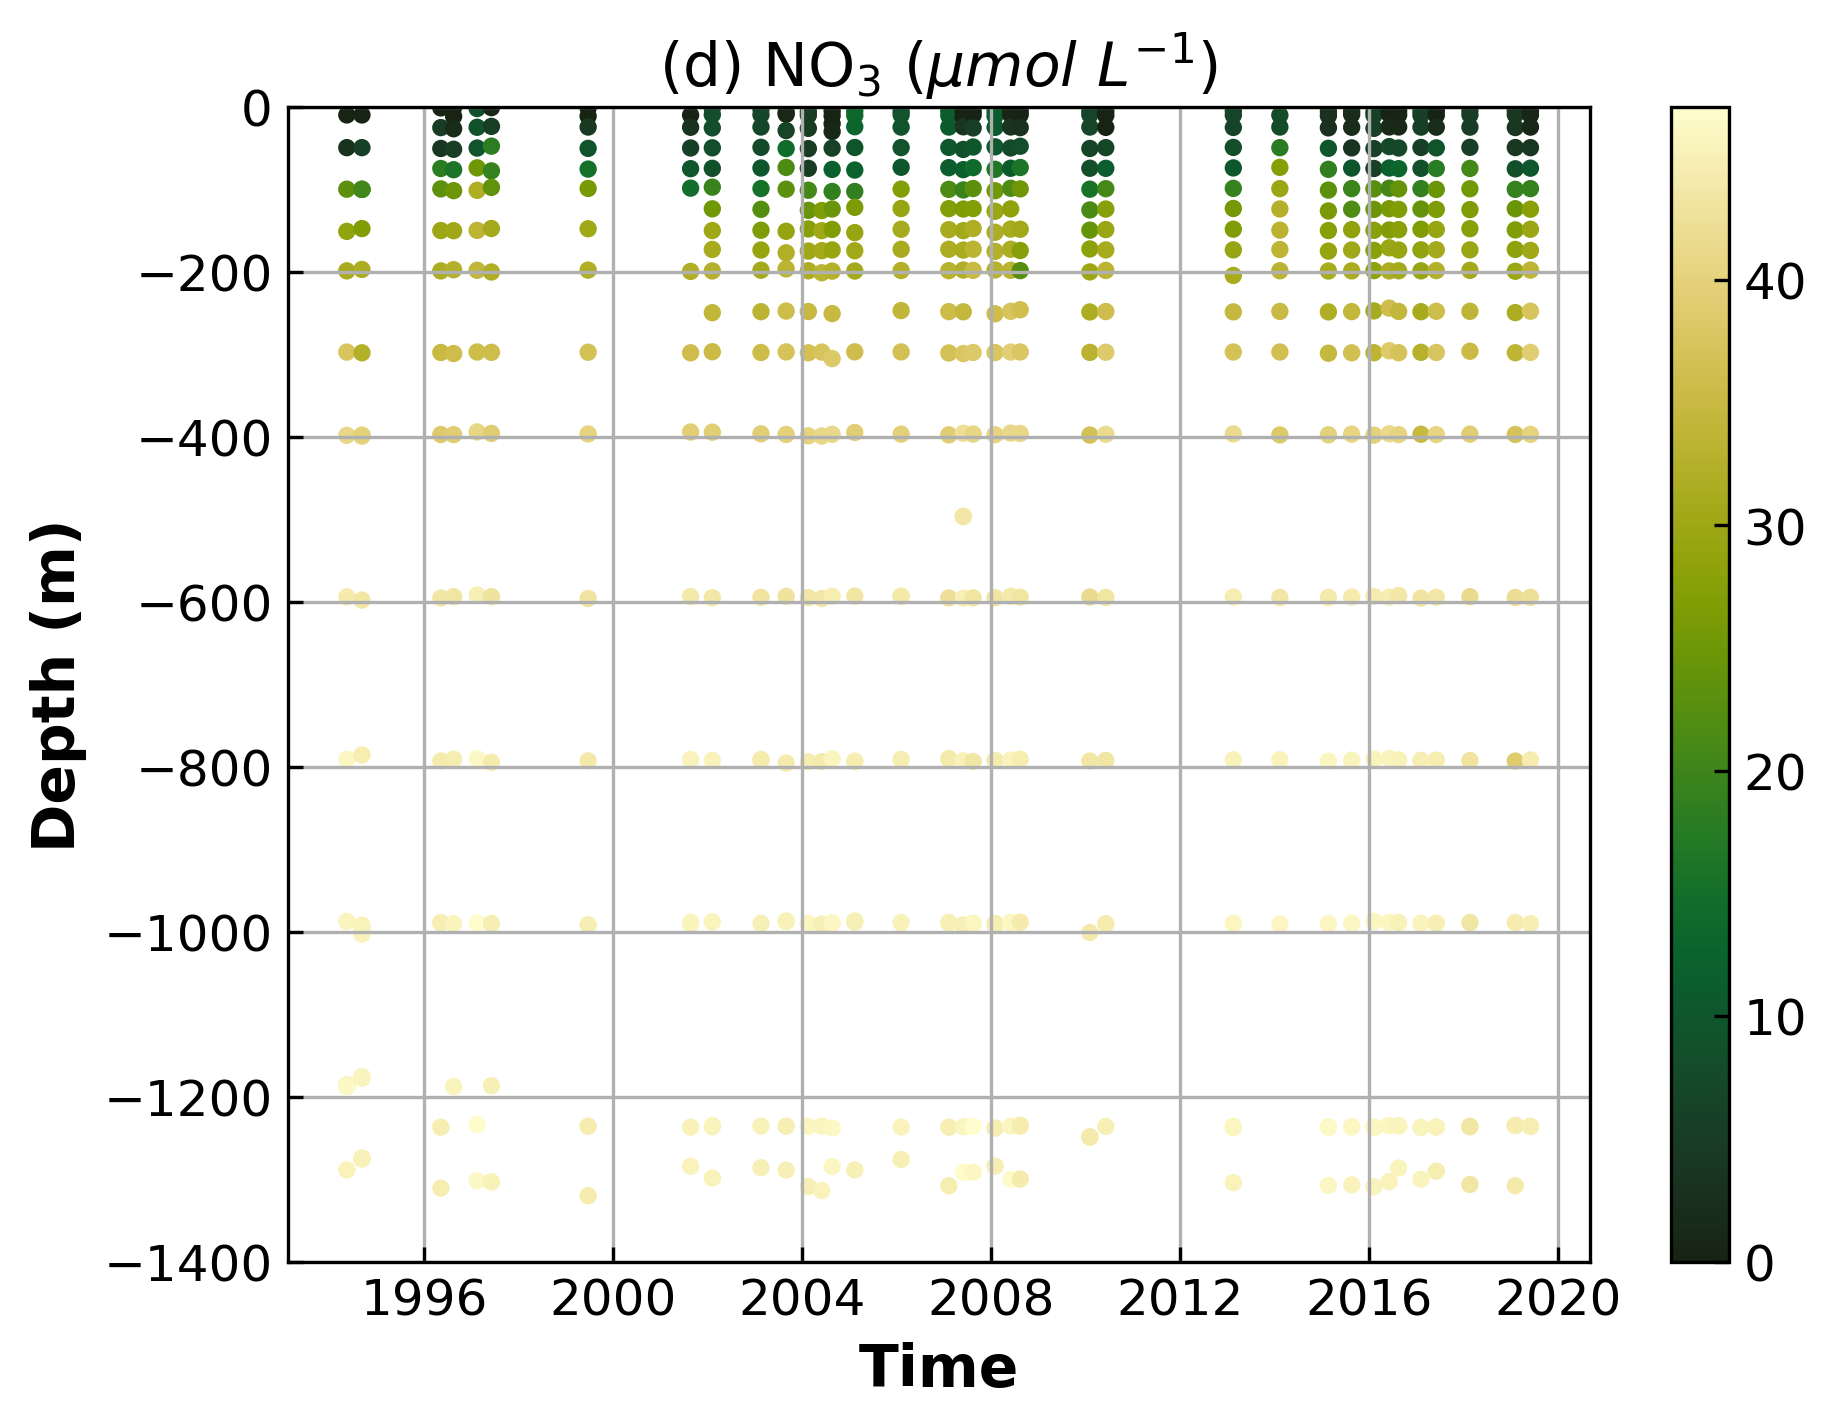

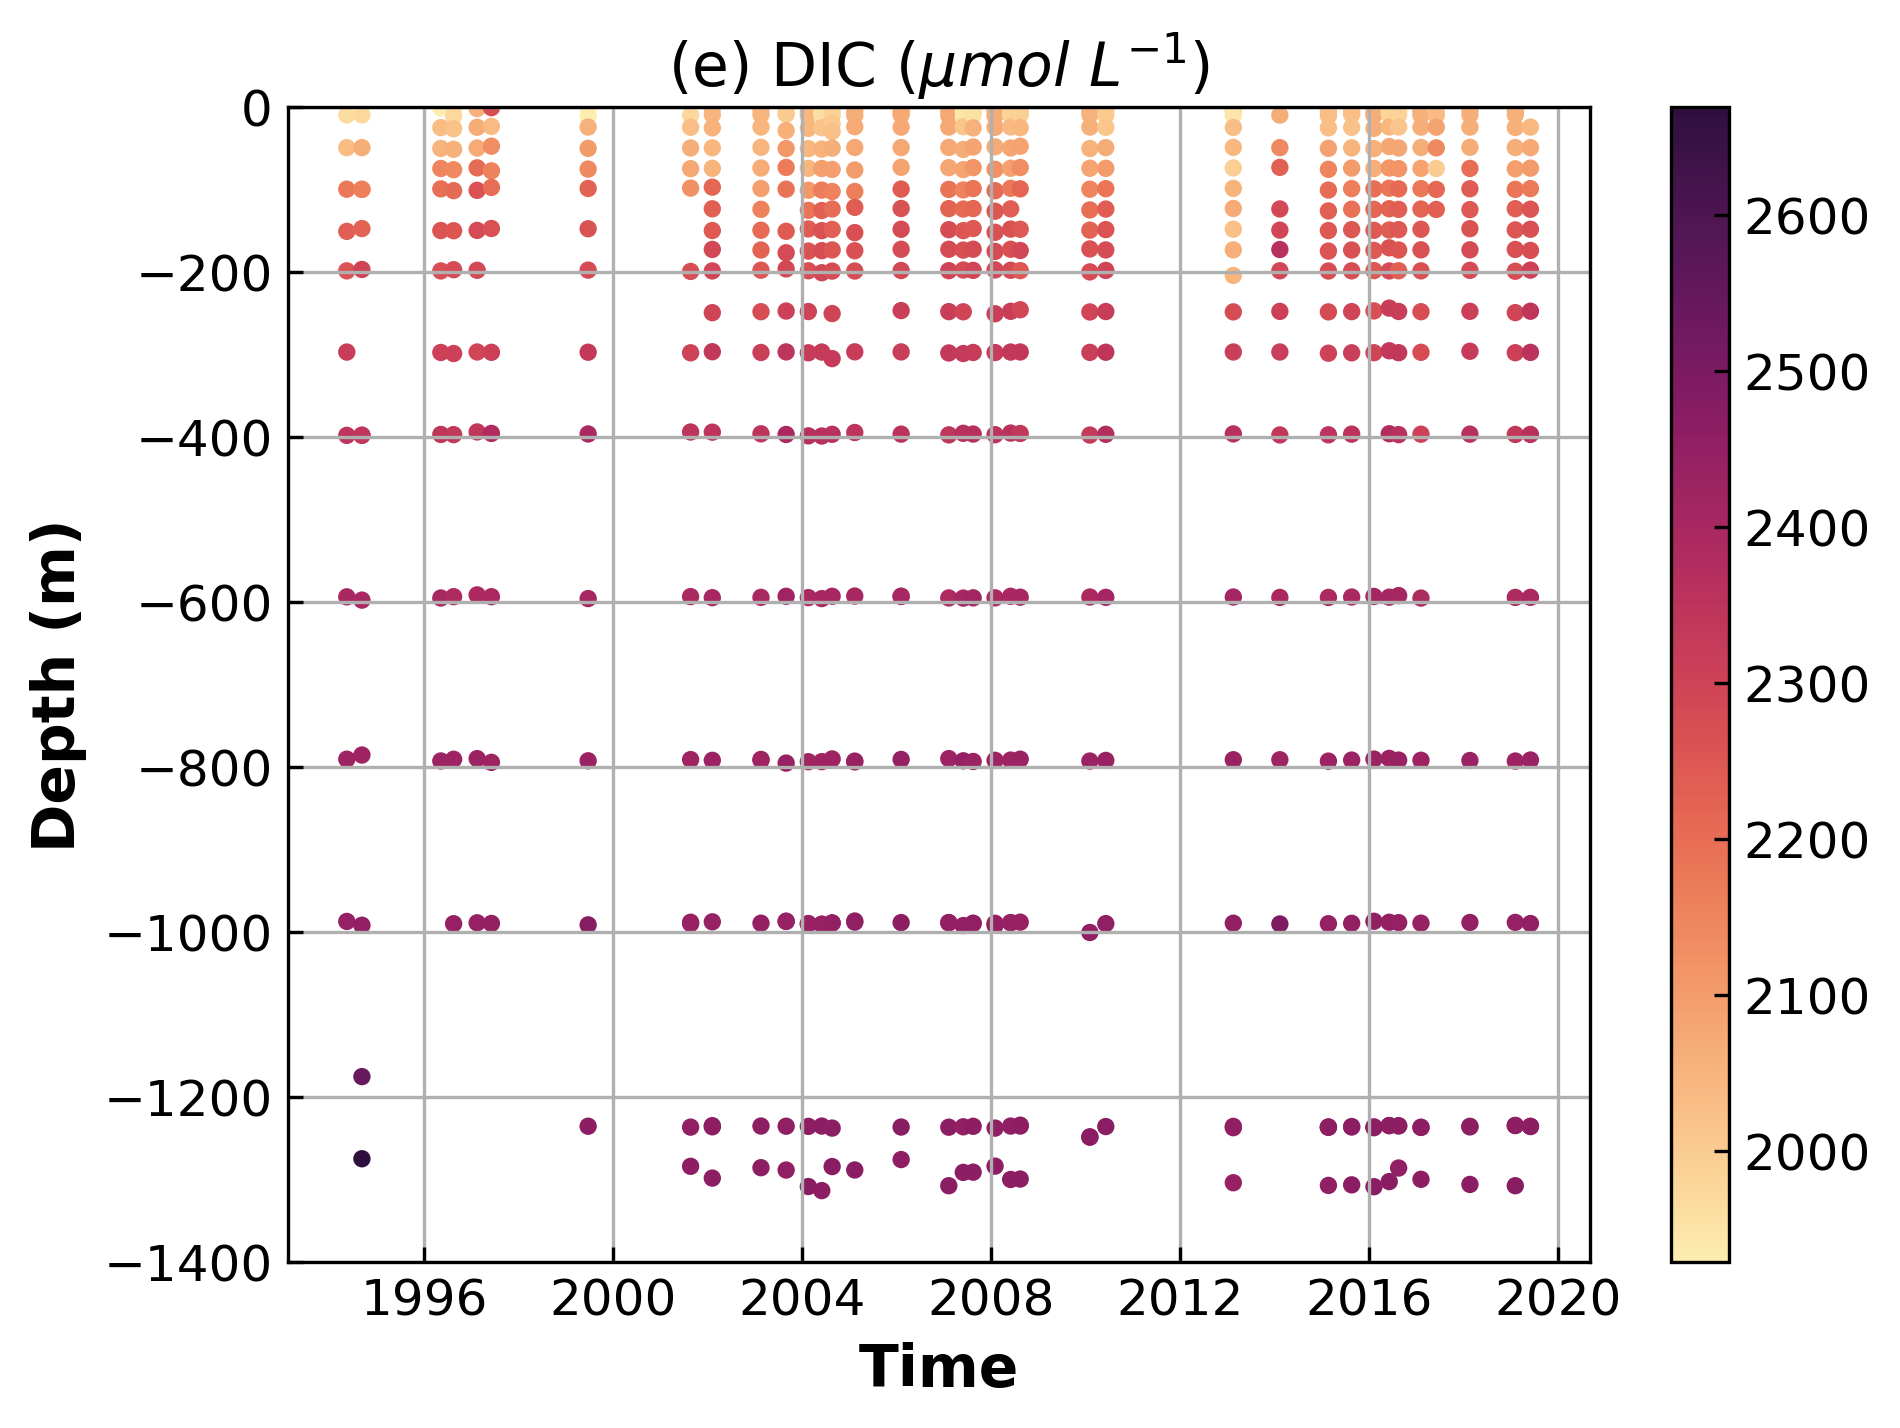

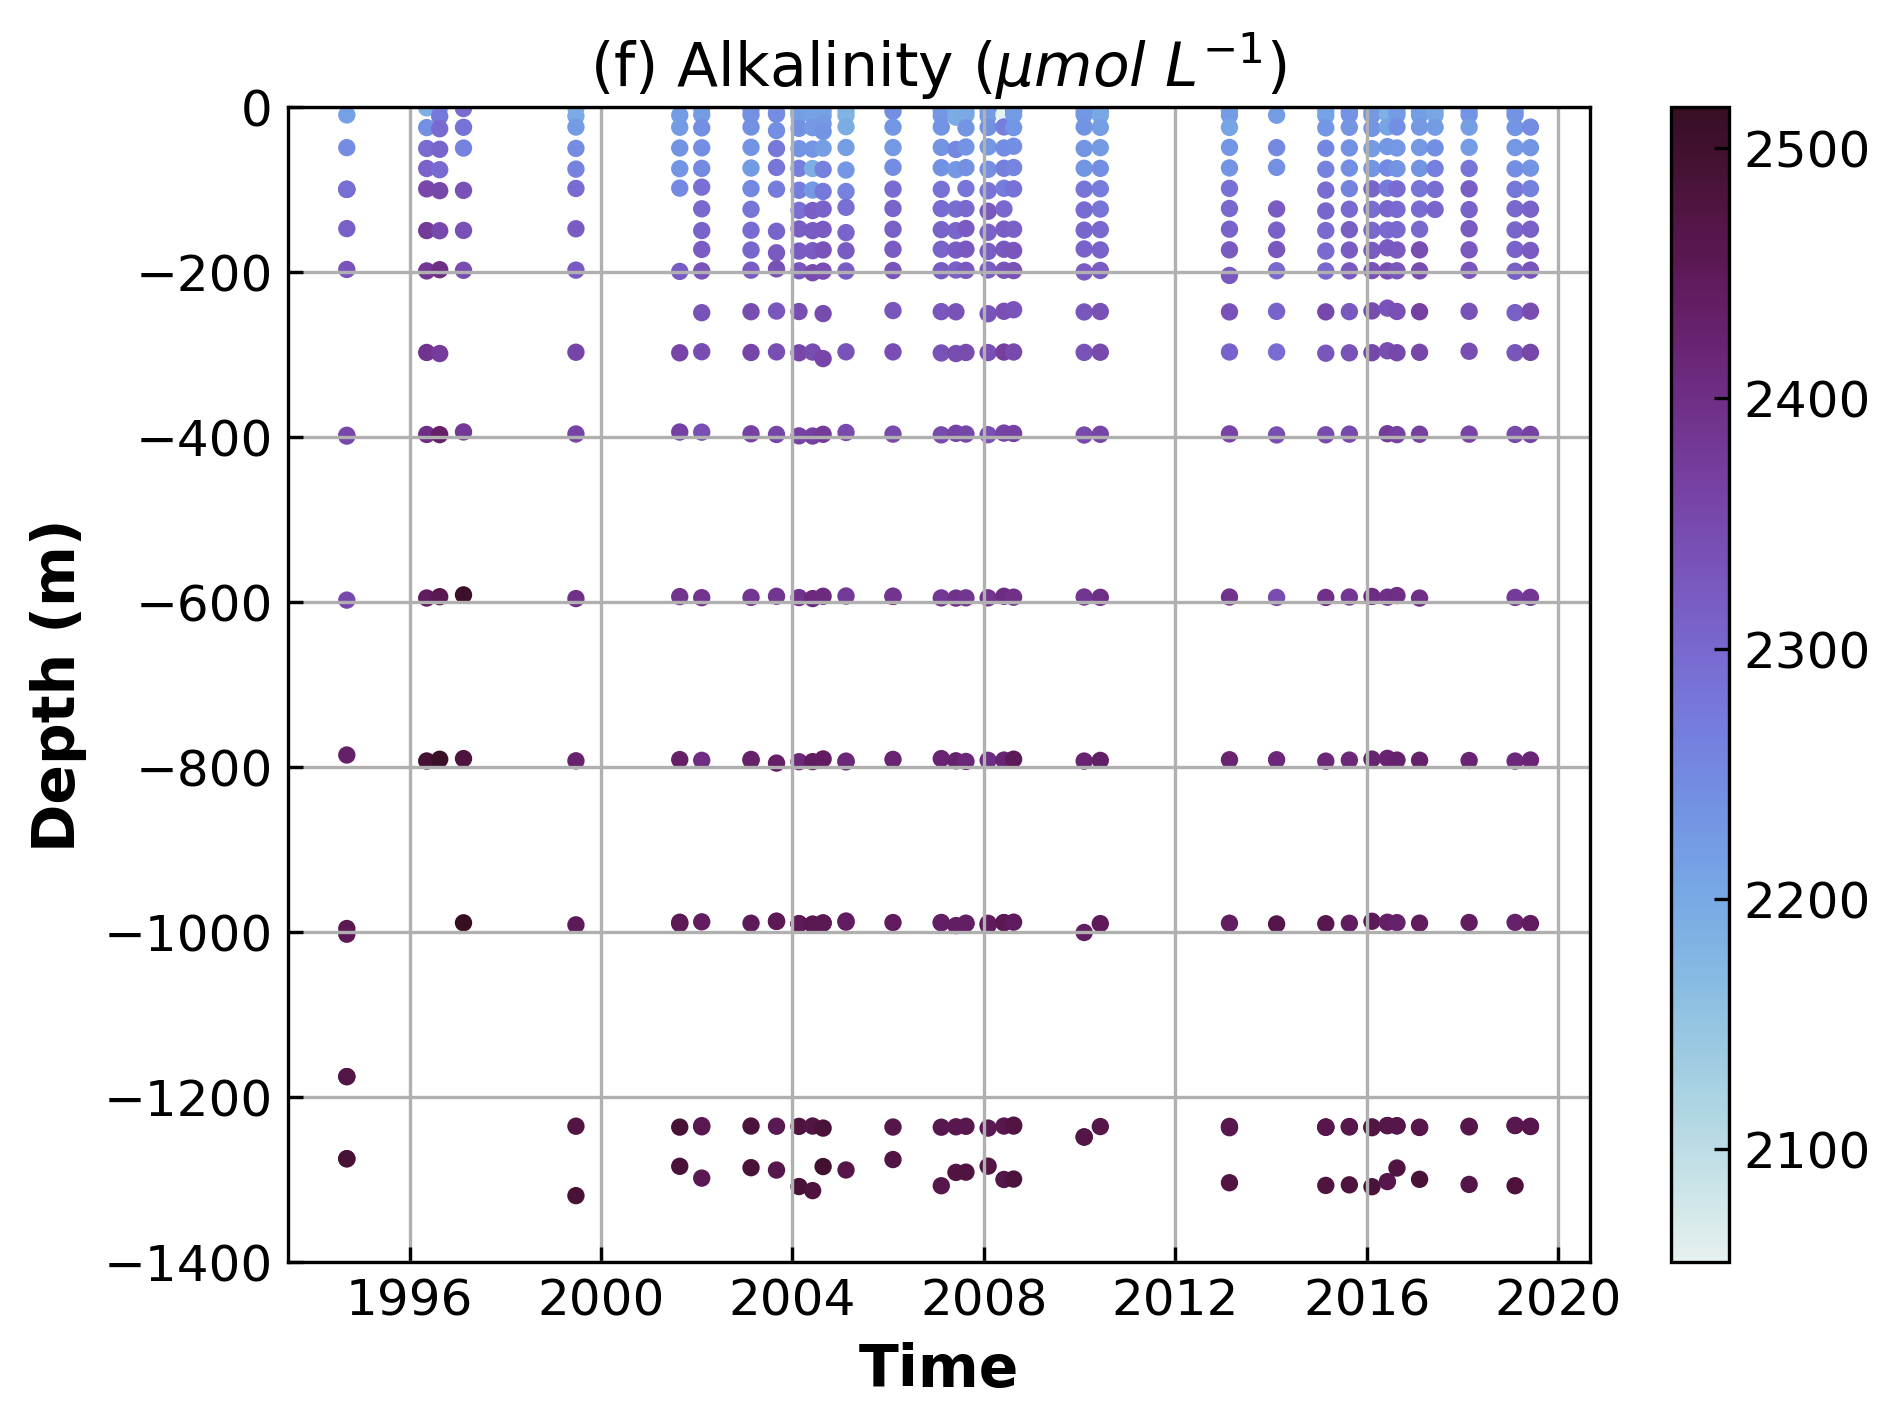

In [7]:
for vn in vn_list:
    fig = plt.figure(figsize = (7,5), dpi = 300)
    plt.scatter(x['time'], x['z'], s = 10, c = x[vn], cmap = cm_list[vn])
    plt.ylim([-1400, 0])
    # plt.gca().invert_yaxis() # turn this on if necessary
    plt.title(label_dict[vn], pad=5)
    plt.grid('True')
    plt.xlabel('Time')
    plt.ylabel('Depth (m)')
    cb = plt.colorbar()
    # cb.set_label(label_dict[vn], rotation=270, labelpad=15)
    plt.show()

### 2D Grid Construction
* Sampling at station P4 is irregular — observations may occur in February, March, July, August, or December, depending on the year.

* To standardize the temporal resolution, create a yearly time axis. For each year, average all available months to represent that year.

* For the vertical axis, data are sparse. Define 10-meter depth bins, and apply interpolation along depth to fill missing values within each year.

* Use np.meshgrid to generate the 2D coordinate arrays for plotting.

* Finally, use pcolor to visualize the gridded time–depth field.

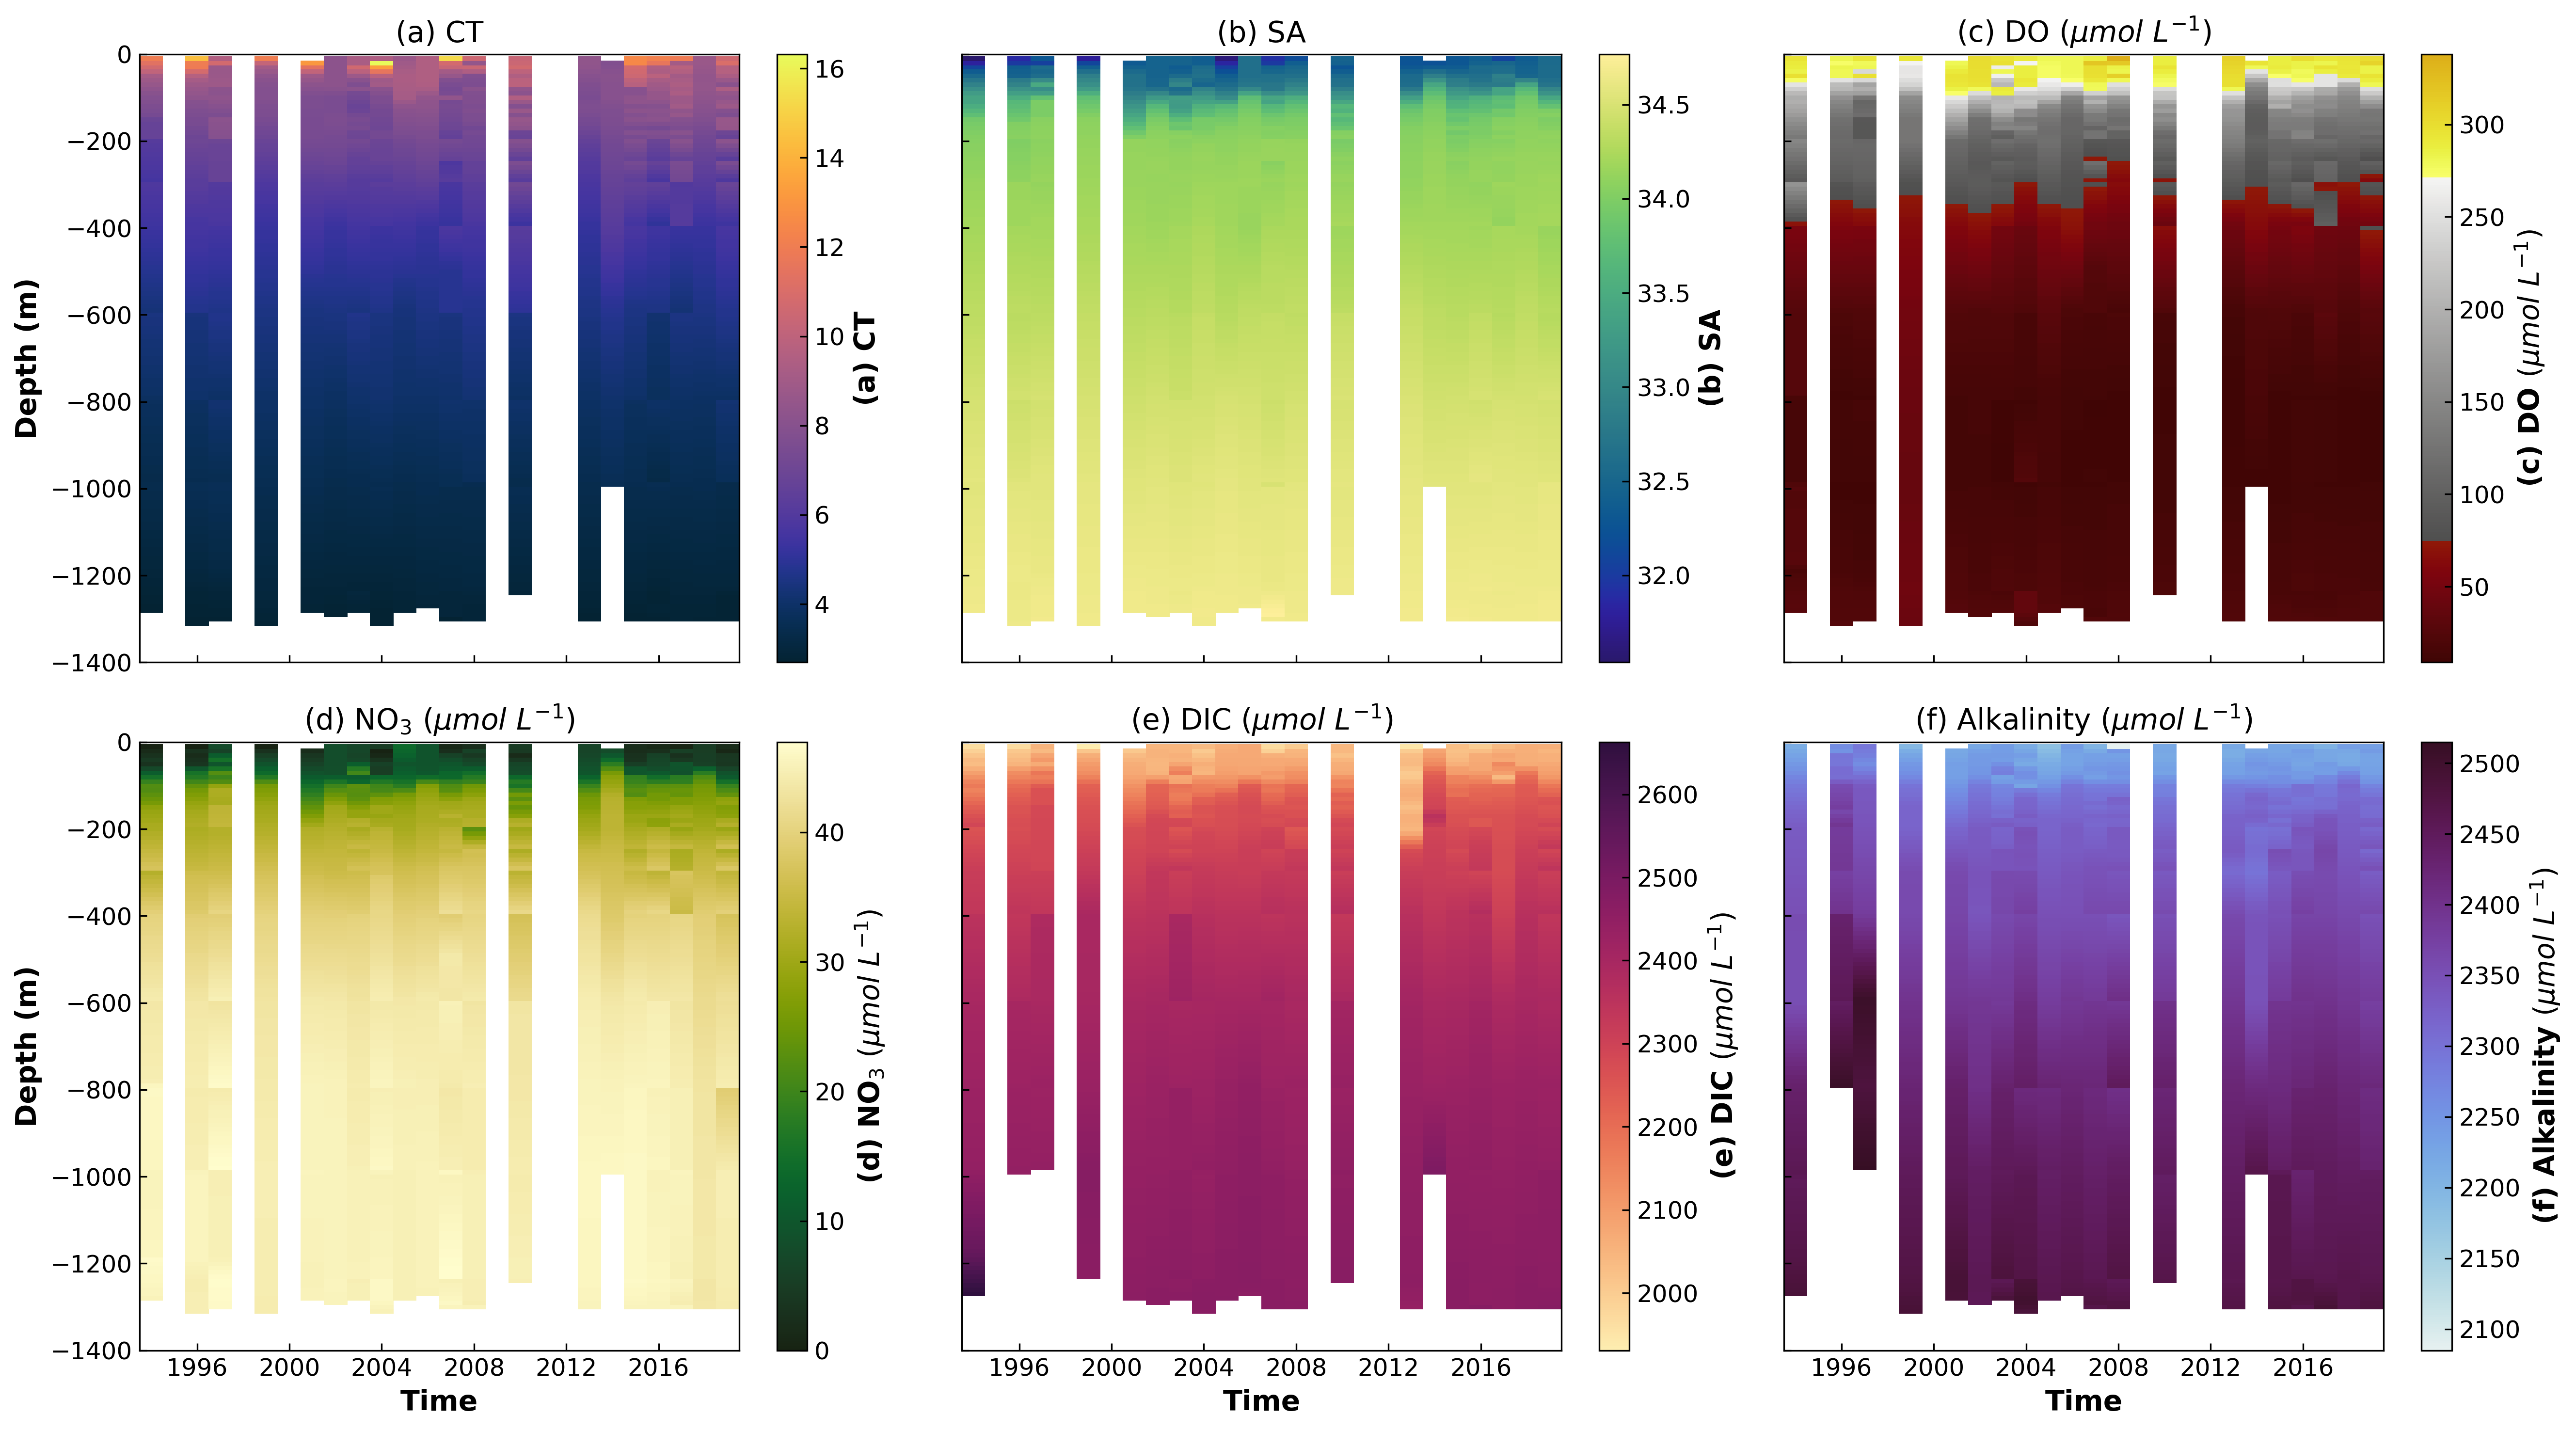

In [8]:
# Ensure 'time' is datetime
xx = x.copy()
xx['time'] = pd.to_datetime(xx['time'])

# Create a continuous yearly range from start to end
start_year = xx['time'].dt.year.min()
end_year = xx['time'].dt.year.max()
TT = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='YS')  # YS = Year Start
time_bins = TT.to_period('Y')

# Create depth bins (10m)
z_bins = np.arange(-1400, 0+10, 10)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi=300, sharex=True, sharey=True)
axs = axs.flatten()

# Loop over vn_list
for k, vn in enumerate(vn_list):
    
    # 1. Create 2D grid with all NaNs (empty grids with row = number of depth bins (z_bins), columns = number of time bins (time_bins)
    H = np.full((len(z_bins), len(time_bins)), np.nan)
    
    # 2. Loop over each year
    for i, year in enumerate(time_bins):
        data = xx[xx['time'].dt.to_period('Y') == year]
        if data.empty:
            continue
        # Remove NaNs
        valid = (~data['z'].isna()) & (~data[vn].isna())
        data = data.loc[valid]
        if len(data) < 2:
            continue
        try:
            # fill gaps using linear interpolation
            f_interp = interp1d(data['z'], data[vn], kind='linear', bounds_error=False, fill_value=np.nan)
            H[:, i] = f_interp(z_bins)
            
        except Exception as e:
            print(f"Interpolation failed for {vn} year {year}: {e}")
            continue

    # Plot for each subplot
    ax = axs[k] # call ax 
    # Create meshgrid
    T, Z = np.meshgrid(time_bins.to_timestamp(), z_bins) 
    # pcolormap
    pcm = ax.pcolor(T, Z, H, cmap=cm_list[vn], shading='auto')   
    ax.set_ylim([-1400, 0]) # set y limit
    # ax.invert_yaxis()  # turn this on if necessary depending on if z is negative or positive    
    ax.set_title(label_dict[vn]) # set title
    
    if k % 3 == 0:
        ax.set_ylabel('Depth (m)')
    if k >= 3:
        ax.set_xlabel('Time')
    fig.colorbar(pcm, ax=ax, orientation='vertical', label=label_dict[vn])

# Clean up any unused subplots
for j in range(len(vn_list), 6):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig(f'{out_dir}/P4_obs_time_series_2D_plot.png')
plt.show()


### See the difference if not interpolating data on the vertical axis

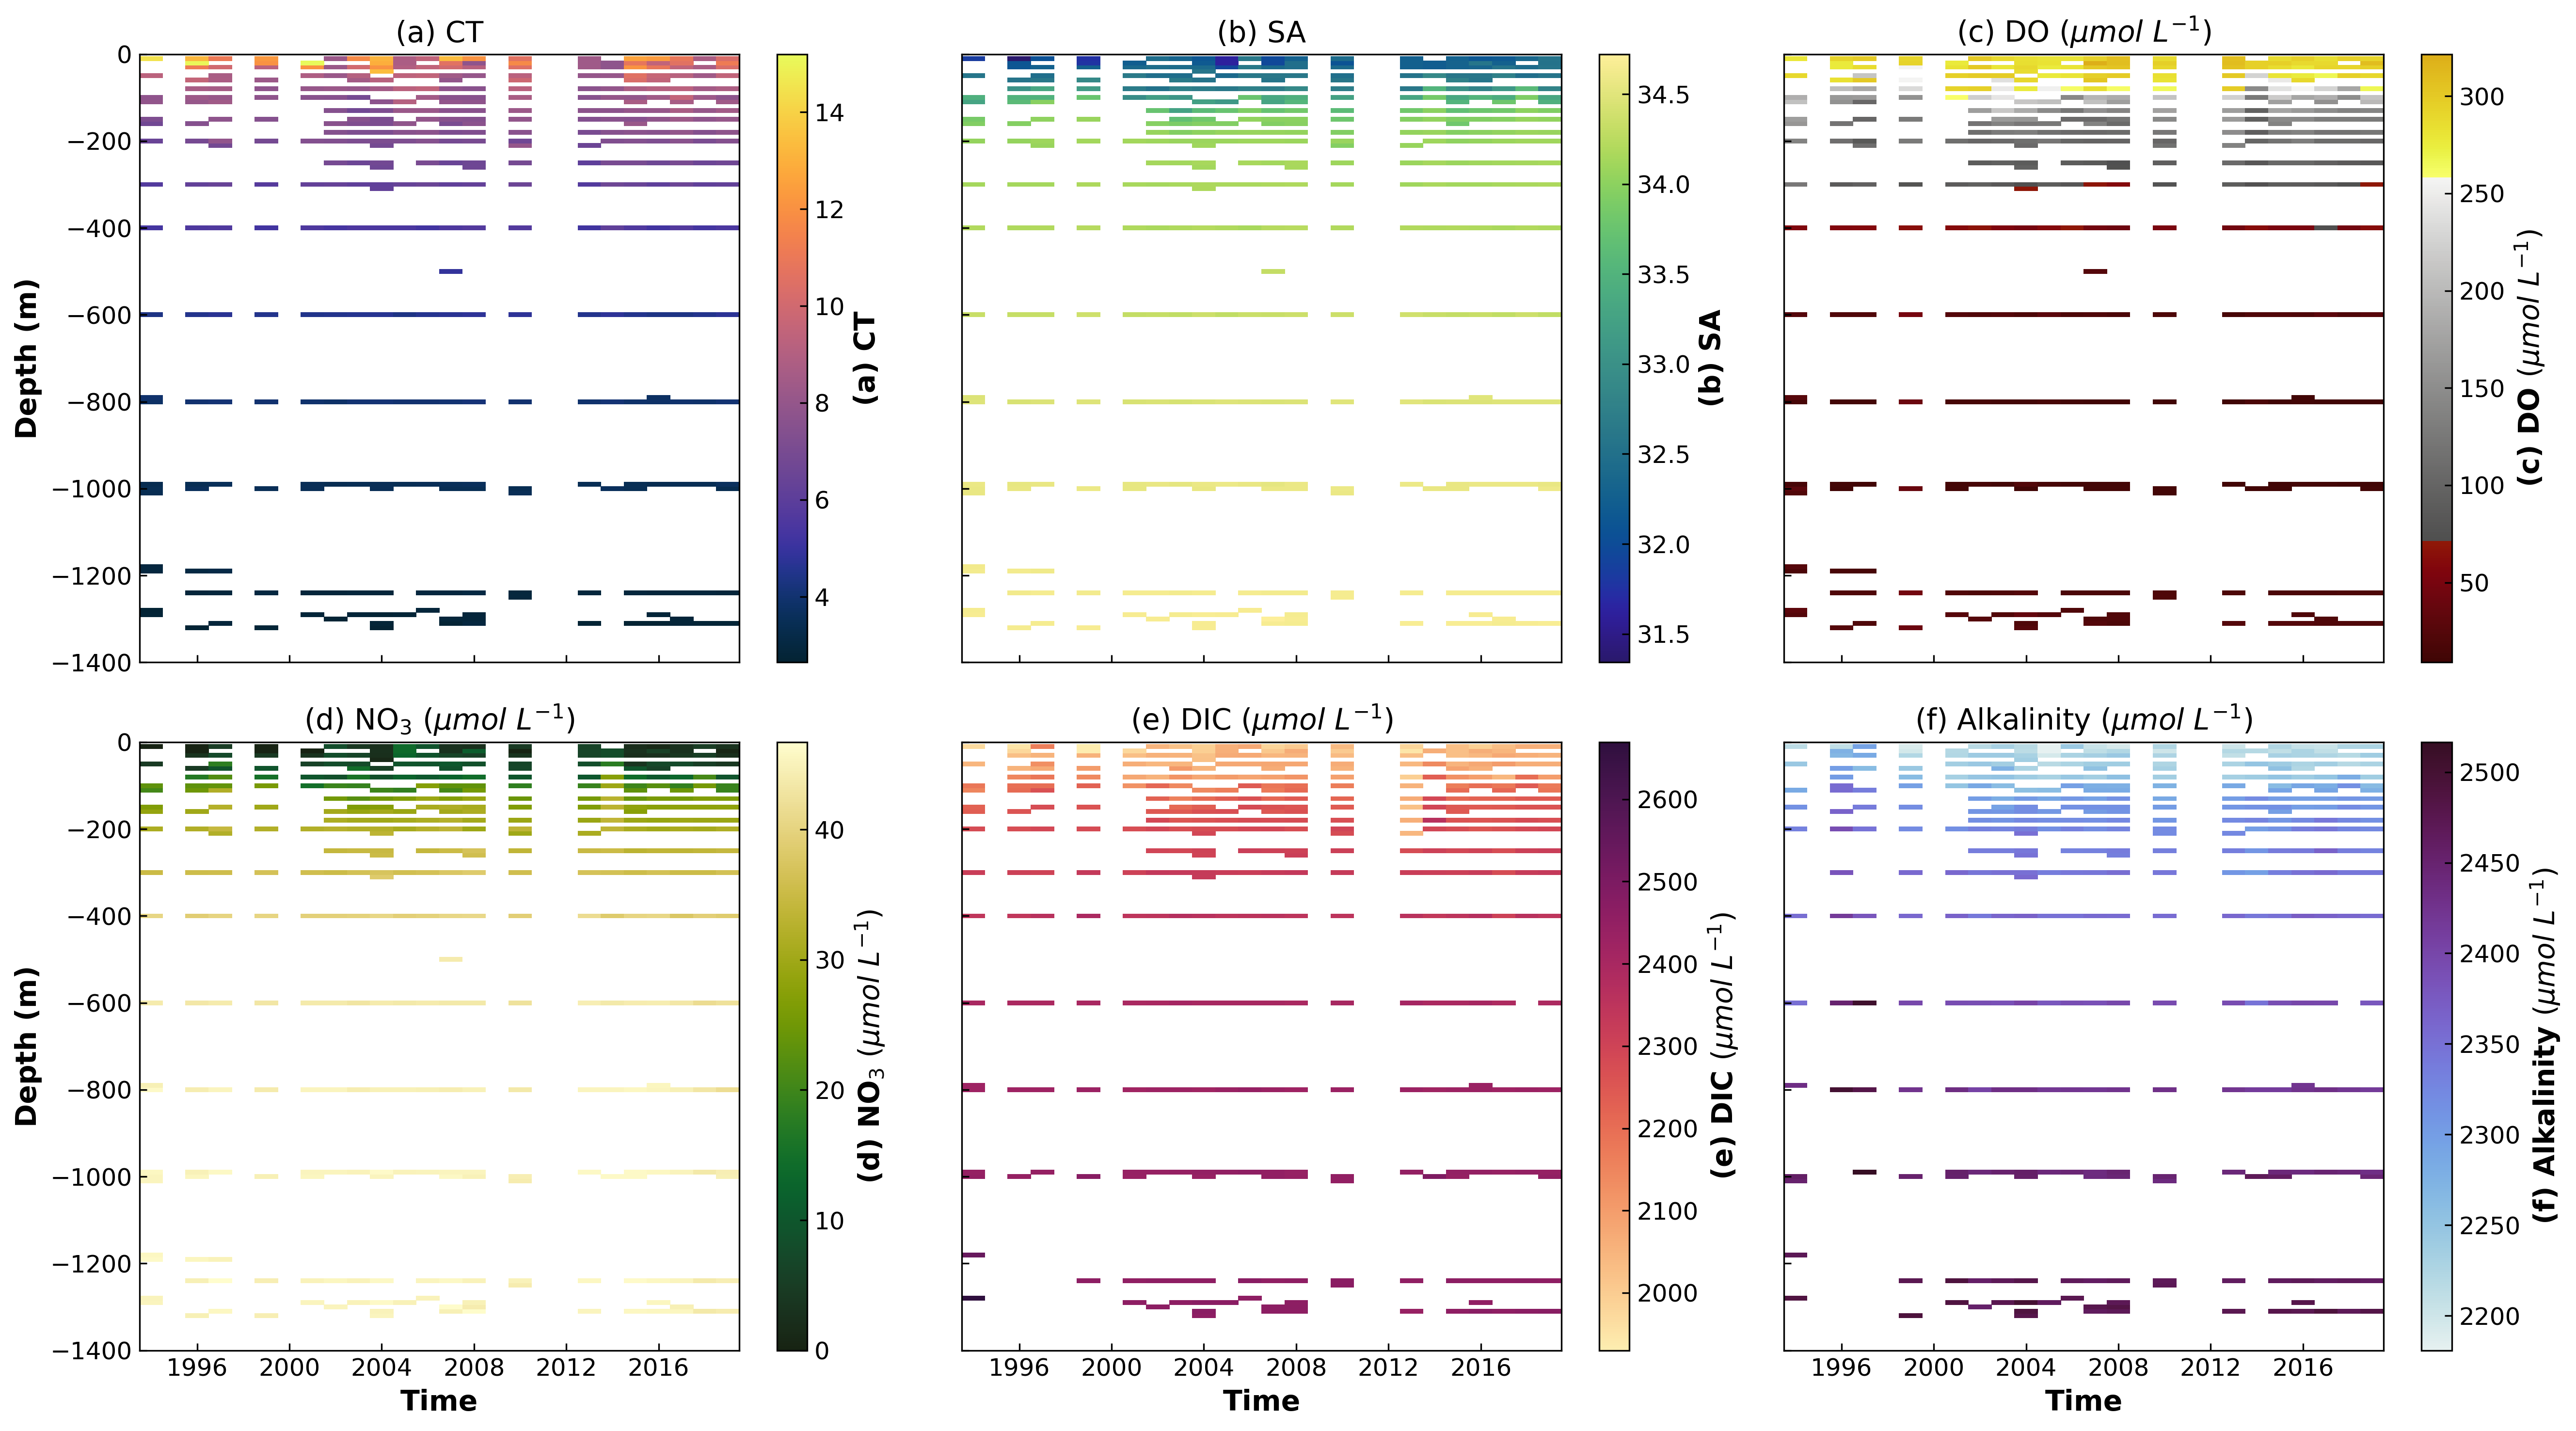

In [9]:
# Ensure 'time' is datetime
xx = xx.copy()
xx['time'] = pd.to_datetime(xx['time'])

# Create a continuous yearly range from start to end
start_year = xx['time'].dt.year.min()
end_year = xx['time'].dt.year.max()
period = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='YS')  # YS = Year Start
# Define year bins
time_bins = period.to_period('Y')

# Create depth bins (10m)
z_bins = np.arange(-1400, 0+10, 10)
# Create 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi=300, sharex=True, sharey=True)
axs = axs.flatten()

# Loop over each variable
for k, vn in enumerate(vn_list):
    # Initialize 2D grid with NaNs
    H = np.full((len(z_bins), len(time_bins)), np.nan)

    """ 
    instead of interpolating, fill the data by averaging available data
    """ 
    for i, year in enumerate(time_bins):
        data = xx[xx['time'].dt.to_period('Y') == year]
        for j in range(len(z_bins)-1):
            mask = (data['z'] >= z_bins[j]) & (data['z'] < z_bins[j+1])
            vals = data.loc[mask, vn]
            if not vals.empty:
                H[j, i] = vals.mean()

    # Create meshgrid
    T, Z = np.meshgrid(time_bins.to_timestamp(), z_bins)

    # Plot in subplot
    ax = axs[k]
    pcm = ax.pcolor(T, Z, H, cmap=cm_list[vn], shading='auto')
    ax.set_ylim([-1400, 0])
    # ax.invert_yaxis()
    ax.set_title(label_dict[vn])
    if k % 3 == 0:
        ax.set_ylabel('Depth (m)')
    if k >= 3:
        ax.set_xlabel('Time')
    fig.colorbar(pcm, ax=ax, orientation='vertical', label=label_dict[vn])

# Remove unused subplots if vn_list < 6
for j in range(len(vn_list), 6):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [10]:
""" 
note: if your wirewalker data only have pressure 

convert your pressure into depth using examples below:

    import gsw
    #Next make derived quantities and do unit conversions
    ### (1) Create CT, SA, and z
    ### - pull out variables
    SP = df.SP.to_numpy()
    IT = df.IT.to_numpy()
    p = df['P (dbar)'].to_numpy()
    lon = df.lon.to_numpy()
    lat = df.lat.to_numpy()
    ### - do the conversions
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, IT, p)
    z = gsw.z_from_p(p, lat)
    ### - add the results to the DataFrame
    df['SA'] = SA
    df['CT'] = CT
    df['z'] = z
    rho = gsw.rho(SA,CT,p)
  
    ### (2) units
    for vn in ['DO','NO3', 'PO4', 'SIO4','TA','DIC']:
        if (vn+' (umol/kg)') in df.columns:
            df[vn+' (uM)'] = (rho/1000) * df[vn+' (umol/kg)']

  """ 


" \nnote: if your wirewalker data only have pressure \n\nconvert your pressure into depth using examples below:\n\n    import gsw\n    #Next make derived quantities and do unit conversions\n    ### (1) Create CT, SA, and z\n    ### - pull out variables\n    SP = df.SP.to_numpy()\n    IT = df.IT.to_numpy()\n    p = df['P (dbar)'].to_numpy()\n    lon = df.lon.to_numpy()\n    lat = df.lat.to_numpy()\n    ### - do the conversions\n    SA = gsw.SA_from_SP(SP, p, lon, lat)\n    CT = gsw.CT_from_t(SA, IT, p)\n    z = gsw.z_from_p(p, lat)\n    ### - add the results to the DataFrame\n    df['SA'] = SA\n    df['CT'] = CT\n    df['z'] = z\n    rho = gsw.rho(SA,CT,p)\n  \n    ### (2) units\n    for vn in ['DO','NO3', 'PO4', 'SIO4','TA','DIC']:\n        if (vn+' (umol/kg)') in df.columns:\n            df[vn+' (uM)'] = (rho/1000) * df[vn+' (umol/kg)']\n\n  "

In [11]:
z_bins

array([-1400, -1390, -1380, -1370, -1360, -1350, -1340, -1330, -1320,
       -1310, -1300, -1290, -1280, -1270, -1260, -1250, -1240, -1230,
       -1220, -1210, -1200, -1190, -1180, -1170, -1160, -1150, -1140,
       -1130, -1120, -1110, -1100, -1090, -1080, -1070, -1060, -1050,
       -1040, -1030, -1020, -1010, -1000,  -990,  -980,  -970,  -960,
        -950,  -940,  -930,  -920,  -910,  -900,  -890,  -880,  -870,
        -860,  -850,  -840,  -830,  -820,  -810,  -800,  -790,  -780,
        -770,  -760,  -750,  -740,  -730,  -720,  -710,  -700,  -690,
        -680,  -670,  -660,  -650,  -640,  -630,  -620,  -610,  -600,
        -590,  -580,  -570,  -560,  -550,  -540,  -530,  -520,  -510,
        -500,  -490,  -480,  -470,  -460,  -450,  -440,  -430,  -420,
        -410,  -400,  -390,  -380,  -370,  -360,  -350,  -340,  -330,
        -320,  -310,  -300,  -290,  -280,  -270,  -260,  -250,  -240,
        -230,  -220,  -210,  -200,  -190,  -180,  -170,  -160,  -150,
        -140,  -130,

In [12]:
time_bins

PeriodIndex(['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
             '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
             '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
             '2018', '2019'],
            dtype='period[Y-DEC]')

In [13]:
time_bins.to_timestamp()

DatetimeIndex(['1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')